# Shadow State Tomography

**Shadow State Tomography** is a method used in quantum computing to estimate the properties of a quantum state without directly measuring it. It involves indirectly characterizing the state of a quantum system by observing its effect on another known state. It is particularly useful in scenarios where direct measurements are impractical due to limitations in measurement precision, experimental resources, or system complexity [1-3].


![image.png](Fig1_shadowtomography.png) 

*Fig.1. Any quantum object is described by its density matrix. To estimate its quantum state we can choose a random angle to perform projective measurements.  In such a way we can collect different classical shadows of a given quantum  state. Image source [3].*

## 1. Purpose and Motivation

Shadow State Tomography is a powerful tool for advancing the capabilities of quantum computing, offering efficient, scalable, and precise methods for state estimation in a diverse range of quantum applications. Here are just a few of the tool's benefits:

- Because the method estimates the properties of quantum states indirectly without exhaustively measuring the state's components, it **leads to reduced measurement complexity and resource** (e.g. money, time, equipment) requirements.

- Statistical techniques can then be used to analyze the measurement outcomes in order to infer properties of the quantum system.

- By indirectly characterizing quantum states through controlled interactions with known states, Shadow State Tomography offers valuable insights into the behavior, properties, and dynamics of quantum systems. This can lead to a better understanding of quantum phenomena, quantum technologies and applications.

## 2. Theory Behind the Problem and our Approach

We can divide the **Shadow State Tomography** process into key steps:

- **Select the state**: A known quantum state, these are typically chosen to be simple and easy to prepare. This state should have well-defined properties that are easy to measure.

- **Create interaction**: The quantum system of interest interacts with the known state through a controlled operation. This interaction entangles the two states, creating a combined or "shadow" state.

- **Measurements**: Measurements are performed on the known state and the combined state. These measurements provide information about the correlation between the known state and the system state.

- **Results analysis**: By analyzing the measurement outcomes, statistical techniques can be used to infer properties of the quantum system. By comparing the observed correlations with theoretical predictions, one can estimate the quantum state of the system.


For Shadow State Tomography using **Rivet transpilation**, we aim to reconstruct the density matrix corresponding to the original circuit. We begin by constructing a list of measurement circuits, each designed to rotate measurement bases.

## 3. Installation and Imports
To run the code below make sure you have followed and installed Rivet transpiler. Check the installation steps from   **Readme.md**.

#### 3.1. Import Qiskit and Rivet Transpiler Functions Required to Run the Examples Below

In [ ]:
import numpy as np

from time import time
from tqdm import tqdm

import qiskit

from qiskit_aer import AerSimulator
from qiskit.visualization import plot_gate_map 

from qiskit_ibm_runtime.fake_provider import FakeLimaV2
from qiskit_ibm_runtime.fake_provider import FakeMontrealV2

from qiskit.circuit.random import random_circuit

import matplotlib.pyplot as plt

plt.style.use("dark_background")

%cd ../..

from rivet_transpiler import transpile_right

#### 3.2. Import Backend

Available backends from IBM Qiskit are listed at [4]. Some backend examples:
- the simplest 5qubit backend (for a simple test start from this one): `FakeBackend5QV2`
- 5qubit backend with noise:  `FakeLimaV2`
- 32-qubit backend: `FakeMontrealV2` 

In [ ]:
FAKE_BACKEND = FakeMontrealV2()
backend = AerSimulator.from_backend(FAKE_BACKEND)
backend.options.noise_model = None
qiskit.visualization.plot_gate_map(FAKE_BACKEND)

![image.png](Fig2_fakeMontrealbackend.png) 

*Fig.2. Schematic representation of FakeMontrealV2 backend.*

#### 3.3. Functions

In [3]:
def get_ghz_circuit(qubits_count):

    qubits = list(range(qubits_count))

    circuit = qiskit.QuantumCircuit(qubits_count)

    circuit.h(0)

    for control, target in zip(qubits, qubits[1:]):

        circuit.cx(control, target)

    return circuit

In [4]:
def rotate_qubit_to_basis(circuit, qubit, basis):

    if basis == "X":
        circuit.h(qubit)

    elif basis == "Y":
        circuit.sdg(qubit)
        circuit.h(qubit)

    elif basis == "Z":
        pass

In [5]:
def build_bases_rotation_circuit(bases):

    qubits_count = len(bases)

    circuit = qiskit.QuantumCircuit(qubits_count)

    for qubit, basis in enumerate(bases):

        if basis == "X":
            circuit.h(qubit)

        elif basis == "Y":
            circuit.sdg(qubit)
            circuit.h(qubit)

        elif basis == "Z":
            pass

    return circuit

In [6]:
def get_inverted_channel(channel, qubits_count):

    identity = np.eye(2 ** qubits_count)

    inverted_channel = (2 ** qubits_count + 1) * channel - identity

    return inverted_channel

In [7]:
def get_basis_unitary(basis):

    if basis == "X":
        unitary = 1/np.sqrt(2) * np.array([[1.,1.],
                                           [1.,-1.]])
    elif basis == "Y":
        unitary = 1/np.sqrt(2) * np.array([[1.,-1.0j],
                                           [1.,1.j]])
    elif basis == "Z":
        unitary = np.eye(2)

    return unitary

In [8]:
def get_mean_square_error(a, b):

    mean_square_error = np.abs(((a - b) ** 2).mean())

    return mean_square_error

## 4. Experiments and Results


Below for the case  of Shadow State Tomography we will reconstruct density matrix, which corresponds to “original circuit”. We build a list of “measurement circuits” which perform rotation of measurement bases. Then we compare 2 types of transpilation:

- **Basic Transpilation:** every “measurement circuit” is composed to “original circuit” – and then composed circuit is transpiled.

- **Rivet transpilation** using the function `transpile_right`: we transpile “original circuit” only once – and then use `transpile_right` function of Rivet Transpiler – to transpile only “measurement circuit” part.

Since “measurement circuit” is much smaller than “original circuit” – `transpile_right` approach is expected to be much faster.

### 4.1. Set Up a Circuit
#### 4.1.1. Circuit with a Random Seed

In [9]:
QUBITS_COUNT = 3
SU2_LAYERS_COUNT = 10
PARAMETRIZATION_RATIO = 0.25

OPTIMIZATION_LEVEL = 3

SEED = 1234

In [10]:
#import numpy as np
qubits = list(range(QUBITS_COUNT))
rng = np.random.default_rng(SEED) 

#### 4.1.2.  Parametrized SU2 Circuit

In [11]:
# Non-Parametrized Part

left_part = qiskit.QuantumCircuit(QUBITS_COUNT)
right_part = qiskit.QuantumCircuit(QUBITS_COUNT)

non_parametrized_layers_count = SU2_LAYERS_COUNT * 2 * (1 / PARAMETRIZATION_RATIO - 1)

non_parametrized_layers_count = int(non_parametrized_layers_count)

for left_layer in range(non_parametrized_layers_count // 2):
    left_part.rz(0.5, qubits)
    
for right_layer in range(non_parametrized_layers_count // 2):
    right_part.rz(1.5, qubits)   
    
# Parametrized Part

parametrized_part = qiskit.circuit.library.EfficientSU2(
    num_qubits=QUBITS_COUNT,
    reps=SU2_LAYERS_COUNT,
    entanglement="linear",
    skip_final_rotation_layer=True
)

# Compose Parts

parametrized_part = parametrized_part.decompose()

parametrized_circuit = parametrized_part.compose(left_part, front=True)
parametrized_circuit = parametrized_circuit.compose(right_part)

# Bind Parameters

random_parameters = np.random.rand(parametrized_circuit.num_parameters)

circuit = parametrized_circuit.assign_parameters(random_parameters)

print("circuit.depth():", circuit.depth())

# circuit.draw(fold=-1)

circuit.depth(): 100


#### 4.1.3.  Other Circuits

In [12]:
## GHZ Circuit

circuit = get_ghz_circuit(QUBITS_COUNT)
circuit.draw(fold=-1)

## Random Circuit

# circuit = random_circuit(QUBITS_COUNT, depth=20, max_operands=1, measure=False)

┌───┐          
q_0: ┤ H ├──■───────
     └───┘┌─┴─┐     
q_1: ─────┤ X ├──■──
          └───┘┌─┴─┐
q_2: ──────────┤ X ├
               └───┘

### 4.2.  Run Paulis Experiment

In [13]:
TOTAL_SHOTS_COUNT = 1000

- Define Bases

In [14]:
import random
random_bases = rng.choice(['X','Y','Z'], size=(TOTAL_SHOTS_COUNT, QUBITS_COUNT))

bases_list, shots_counts = np.unique(random_bases, axis=0, return_counts=True)

bases_list.shape

(27, 3)

- Define Rotation Circuits

In [15]:
rotation_circuits = []

for bases in bases_list:

    rotation_circuit = build_bases_rotation_circuit(bases)

    rotation_circuits.append(rotation_circuit)

len(rotation_circuits)

27

#### 4.2.1. Basic Transpilation - Slower Version!

To be able run code bellow need to install `tqdm`:


In [16]:
!pip install tqdm

Here we use the simple transpilation while using `transpile` function. 

In [ ]:
start_time = time()
# Compose and Transpile all Rotation Circuits

shadow_circuits = []

rotation_tracker = tqdm(rotation_circuits, unit=' basis', ncols=110)

for rotation_circuit in rotation_tracker:

    measurement_circuit = rotation_circuit.measure_all(inplace=False)

    measured_circuit = circuit.compose(measurement_circuit)

    # display(measured_circuit.draw(fold=-1))

    shadow_circuit = qiskit.transpile(
        measured_circuit,
        backend,
        seed_transpiler=SEED,
        optimization_level=OPTIMIZATION_LEVEL)

    shadow_circuits.append(shadow_circuit)

estimated_time = time() - start_time

print(f"estimated_time: {estimated_time:.02f}")

#### 4.2.2. Transpile Right - Much Faster!
In this case we  run transpilation with `transpile_right` function.

In [ ]:
start_time = time()

# Transpile Central Part

transpiled_central_circuit = qiskit.transpile(
    circuit,
    backend,
    seed_transpiler=SEED,
    optimization_level=OPTIMIZATION_LEVEL)


# Transpile Right all Rotation Circuits

shadow_circuits = []

rotation_tracker = tqdm(rotation_circuits, unit=' basis', ncols=110)

for rotation_circuit in rotation_tracker:

    measurement_circuit = rotation_circuit.measure_all(inplace=False)

    shadow_circuit = transpile_right(
        transpiled_central_circuit,
        measurement_circuit,
        backend=backend,
        seed_transpiler=SEED,
        optimization_level=OPTIMIZATION_LEVEL)

    shadow_circuits.append(shadow_circuit)


estimated_time = time() - start_time

print(f"estimated_time: {estimated_time:.02f}")

#### 4.2.3. Run Shadow Circuits

In [19]:
counts_list = []

for shadow_circuit, shots in zip(shadow_circuits, shots_counts):

    job = backend.run(shadow_circuit, shots=shots)

    counts = job.result().get_counts()

    counts_list.append(counts)

#### 4.2.4. Calculate Shadows

Calculate the shadow matrices for a set of observed states used to estimate the quantum state of the system.

In [20]:
shadows = []

for bases, counts in zip(bases_list, counts_list):

    for state, count in counts.items():

        shadow_part = 1

        for bit_index, bit in enumerate(state[::-1]):

            basis = bases[bit_index]

            basis_unitary = get_basis_unitary(basis)

            vector = basis_unitary[int(bit), :]

            outer_product = np.outer(vector.conj(), vector)

            inverted_channel = get_inverted_channel(outer_product, 1)

            shadow_part = np.kron(inverted_channel, shadow_part)

        shadow = shadow_part * count

        shadows.append(shadow)

#### 4.2.5. Analyze Density Matrices

In [21]:
reconstructed_density_matrix = np.sum(shadows, axis=0) / TOTAL_SHOTS_COUNT

reconstructed_density_matrix.shape

(8, 8)

In [22]:
original_density_matrix = qiskit.quantum_info.DensityMatrix(circuit).data

original_density_matrix.shape

(8, 8)

Below we plot the visualization for **ORIGINAL** and **RECONSTRUCTED** Density Matrices:

In [23]:
def plot_density_matrix(density_matrix, label=""):

    plt.suptitle(f"{label} Density Matrix", y=0.9)

    real = plt.subplot(121)
    real.set_title("Real part")

    real.imshow(density_matrix.real, vmin=-0.7, vmax=0.7)

    real.axes.set_xticks(())
    real.axes.set_yticks(())


    imaginary = plt.subplot(122)
    imaginary.set_title("Imaginary part")
    imaginary.imshow(density_matrix.imag, vmin=-0.7, vmax=0.7)

    imaginary.axes.set_xticks(())
    imaginary.axes.set_yticks(())

    plt.show()

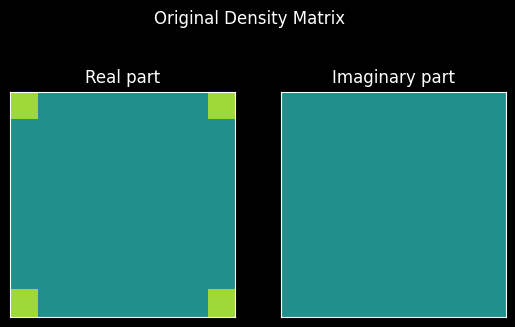

In [24]:
plot_density_matrix(original_density_matrix, label="Original")

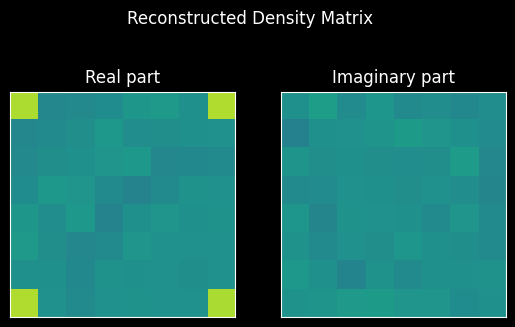

In [25]:
plot_density_matrix(reconstructed_density_matrix, label="Reconstructed")

To measure a Mean Square Error:

In [26]:
mean_square_error = np.abs(((original_density_matrix -
                             reconstructed_density_matrix) ** 2).mean())

mean_square_error

7.362109375000134e-05

### 4.3.  Run Cliffords Experiment

In [27]:
SHADOWS_COUNT = 100
SHOTS_COUNT = 100

cliffords = [qiskit.quantum_info.random_clifford(QUBITS_COUNT, seed=rng)
             for _ in range(SHADOWS_COUNT)]

- Define Rotation Circuits:

In [28]:
rotation_circuits = []

for clifford in cliffords:

    rotation_circuit = clifford.to_circuit()

    rotation_circuits.append(rotation_circuit)

len(rotation_circuits)

100

#### 4.3.1. Basic Transpilation - Slower Version!

In [ ]:
start_time = time()

# Compose and Transpile all Rotation Circuits

shadow_circuits = []

rotation_tracker = tqdm(rotation_circuits, unit=' basis', ncols=110)

for rotation_circuit in rotation_tracker:

    measurement_circuit = rotation_circuit.measure_all(inplace=False)

    measured_circuit = circuit.compose(measurement_circuit)

    # display(measured_circuit.draw(fold=-1))

    shadow_circuit = qiskit.transpile(
        measured_circuit,
        backend,
        seed_transpiler=SEED,
        optimization_level=OPTIMIZATION_LEVEL)

    shadow_circuits.append(shadow_circuit)

estimated_time = time() - start_time

print(f"estimated_time: {estimated_time:.02f}")

#### 4.3.2. Transpile Right - Much Faster!

In [ ]:
start_time = time()

# Transpile Central Part

transpiled_central_circuit = qiskit.transpile(
    circuit,
    backend,
    seed_transpiler=SEED,
    optimization_level=OPTIMIZATION_LEVEL)


# Transpile Right all Rotation Circuits

shadow_circuits = []

rotation_tracker = tqdm(rotation_circuits, unit=' basis', ncols=110)

for rotation_circuit in rotation_tracker:

    measurement_circuit = rotation_circuit.measure_all(inplace=False)

    shadow_circuit = transpile_right(
        transpiled_central_circuit,
        measurement_circuit,
        backend=backend,
        seed_transpiler=SEED,
        optimization_level=OPTIMIZATION_LEVEL)

    shadow_circuits.append(shadow_circuit)


estimated_time = time() - start_time

print(f"estimated_time: {estimated_time:.02f}")

#### 4.3.3.  Run Shadow Circuits

In [31]:
counts_list = []

for shadow_circuit in shadow_circuits:

    job = backend.run(shadow_circuit, shots=SHOTS_COUNT)

    counts = job.result().get_counts()

    counts_list.append(counts)

#### 4.3.4.  Calculate Shadows

Calculate the shadow matrices for a set of observed states used to estimate the quantum state of the system.

In [32]:
shadows = []

for clifford, counts in zip(cliffords, counts_list):

    unitary = clifford.adjoint().to_matrix()

    for state, count in counts.items():

        state_index = int(state, 2)

        vector = unitary[:, state_index]

        outer_product = np.outer(vector, vector.conj())

        inverted_channel = get_inverted_channel(outer_product, QUBITS_COUNT)

        shadow = inverted_channel * count

        shadows.append(shadow)

#### 4.3.5.  Analyze Density Matrices

In [33]:
TOTAL_SHOTS_COUNT = SHADOWS_COUNT * SHOTS_COUNT

reconstructed_density_matrix = np.sum(shadows, axis=0) / TOTAL_SHOTS_COUNT

reconstructed_density_matrix.shape

(8, 8)

In [34]:
original_density_matrix = qiskit.quantum_info.DensityMatrix(circuit).data

original_density_matrix.shape

(8, 8)

Below we plot the visualization for **ORIGINAL** and **RECONSTRUCTED** Density Matrices:

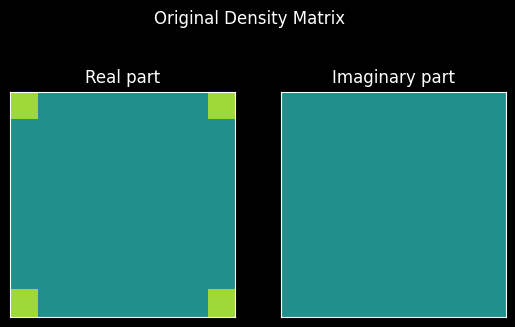

In [35]:
plot_density_matrix(original_density_matrix, label="Original")

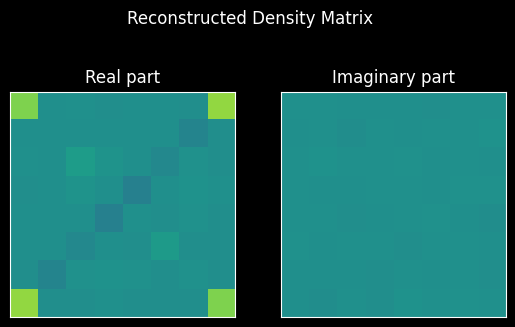

In [36]:
plot_density_matrix(reconstructed_density_matrix, label="Reconstructed")

To measure a Mean Square Error:

In [37]:
get_mean_square_error(original_density_matrix,
                      reconstructed_density_matrix)

0.0007943599999999957

### 4.4.  Compare Transpilation Times
Below we compare the transpilation times for a few circuits (from 2 to 8 qubits) using the basic transpilation and transpilation with a `transpile_right`.

In [38]:
results = np.load("examples/shadows/results.npy",
                  allow_pickle=True).item()
results

{2: {'bases': 9, 'basic_transpilation': 2.15, 'transpile_right': 0.27},
 3: {'bases': 27, 'basic_transpilation': 20.03, 'transpile_right': 1.14},
 4: {'bases': 81, 'basic_transpilation': 82.06, 'transpile_right': 2.74},
 5: {'bases': 243, 'basic_transpilation': 312.58, 'transpile_right': 7.39},
 6: {'bases': 729, 'basic_transpilation': 1150.28, 'transpile_right': 23.47},
 7: {'bases': 2167, 'basic_transpilation': 3939.58, 'transpile_right': 121.01},
 8: {'bases': 5127,
  'basic_transpilation': 10018.36,
  'transpile_right': 271.09}}

In [39]:
basic_times = [results[qubit_count]['basic_transpilation'] for qubit_count in results]

basic_times

[2.15, 20.03, 82.06, 312.58, 1150.28, 3939.58, 10018.36]

In [40]:
right_times = [results[qubit_count]['transpile_right'] for qubit_count in results]

right_times

[0.27, 1.14, 2.74, 7.39, 23.47, 121.01, 271.09]

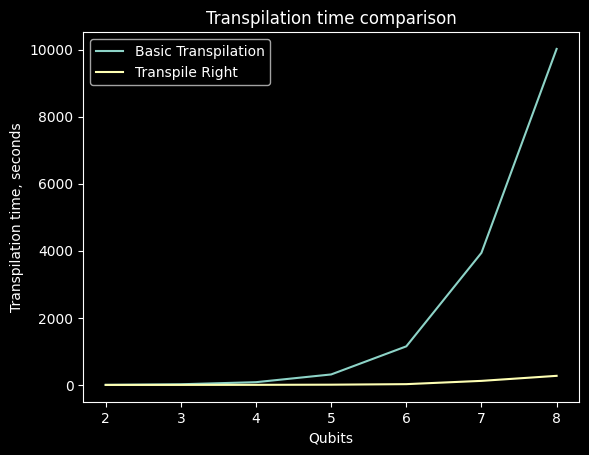

In [41]:
# Plot Transpilation times

qubit_counts = list(results.keys())

plt.title("Transpilation time comparison")
plt.xlabel("Qubits")
plt.ylabel("Transpilation time, seconds")

plt.plot(qubit_counts, basic_times, label="Basic Transpilation")
plt.plot(qubit_counts, right_times, label="Transpile Right")

plt.legend()

plt.show()

## Conclusions

For the shadow state tomography technique we reconstructed the density matrix of the “original circuit” and compared 2 types of transpilation: 
- **Basic Transpilation:** every “measurement circuit” is composed to “original circuit” – and then composed circuit is transpiled.
- **Rivet transpilation** using the function `transpile_right`: we transpile “original circuit” only once – and then use `transpile_right` function of Rivet Transpiler – to transpile only “measurement circuit” part.

Through this experiment, it was shown that using transpile_left is a faster approach.


## References

[1] https://hongyehu.github.io/Hamiltonian-driven-shadow-tomography-page/

[2] https://github.com/ryanlevy/shadow-tutorial/blob/main/Tutorial_Shadow_State_Tomography.ipynb

[3] https://arxiv.org/pdf/2002.08953

[4] Qiskit fake backends https://docs.quantum.ibm.com/api/qiskit/0.37/providers_fake_provider